In [ ]:
!nvidia-smi

Mon Sep 23 16:30:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install numpy==1.22.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
arviz 0.19.0 requires numpy>=1.23.0, but you have numpy 1.22.4 which is incompatible.
astropy 6.1.3 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.
bigframes 1.17.0 requires numpy>=1.24.0, but you have numpy 1.22.4 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
contourpy 1.3.0 requires numpy>=1.23, but you have numpy 1.22.4 whi

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
SOURCE_VIDEO_PATH="/content/drive/MyDrive/Detection/vid2_27_7_FaisalTown.mp4"

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.9/112.6 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()
import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:01<00:00, 110MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 10 persons, 1 bicycle, 8 cars, 1 truck, 1 traffic light, 63.1ms
Speed: 3.6ms preprocess, 63.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


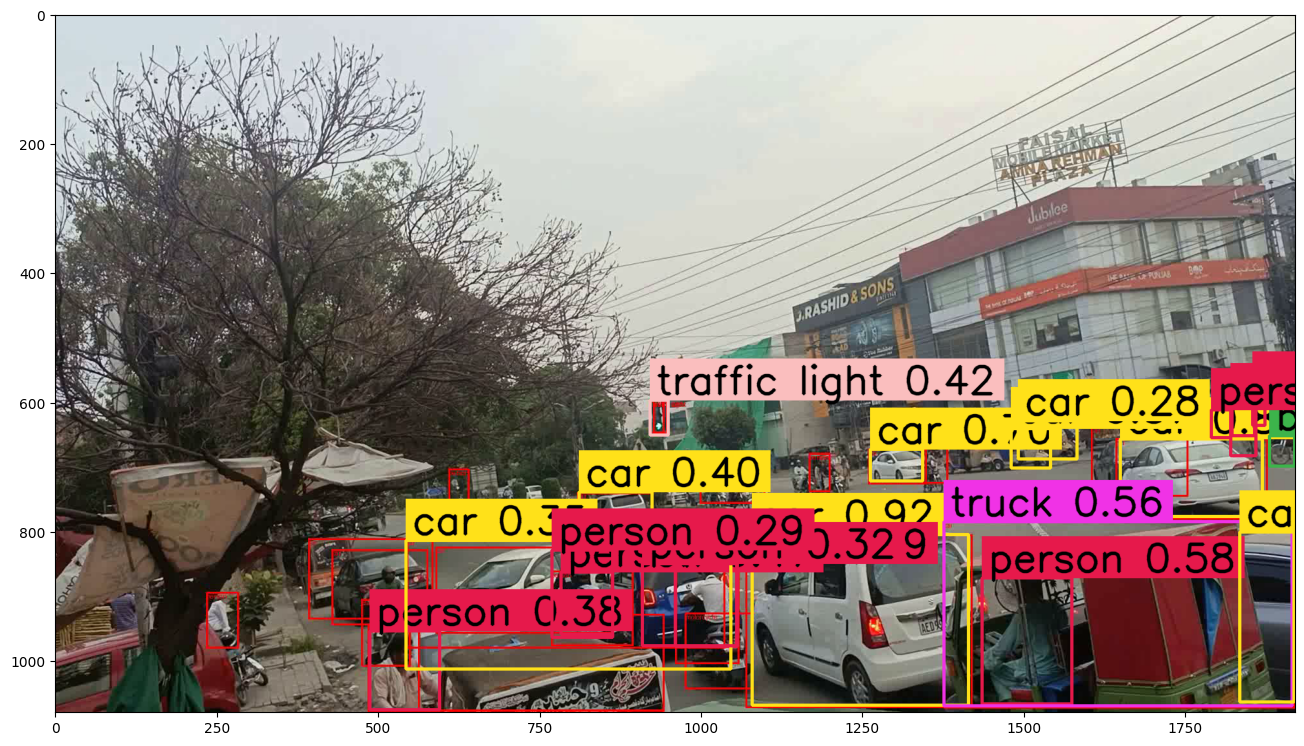

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"/content/drive/MyDrive/Result_ByteTracker/vid2_27_7_FaisalTown.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=26, total_frames=416)

In [ ]:
from collections import deque

# Dictionary to store the history of tracked object positions
object_tracks = {}

# Parameters for trajectory visualization
MAX_TRACK_LENGTH = 30  # Maximum number of previous positions to display

**Line Drawing**


In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
# Import deque for storing the object tracks
from collections import deque
import cv2  # OpenCV for drawing the lines

# Dictionary to store the history of tracked object positions
# Dictionary to store the history of tracked object positions
object_tracks = {}

# Parameters for trajectory visualization
MAX_TRACK_LENGTH = 30  # Maximum number of previous positions to display
TRACK_COLOR = (0, 255, 0)  # Color of the track (Green)
TRACK_THICKNESS = 2  # Thickness of the trajectory line

# Update the VideoSink loop to handle detections and draw object tracks
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        # Filter detections by class of interest
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # Tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # Filter out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # Update object tracks with new positions
        for i in range(len(detections)):
            tracker_id = detections.tracker_id[i]
            # Get the center of the bounding box
            x1, y1, x2, y2 = detections.xyxy[i]
            center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

            # If the object is new, create a deque for it
            if tracker_id not in object_tracks:
                object_tracks[tracker_id] = deque(maxlen=MAX_TRACK_LENGTH)
            object_tracks[tracker_id].append(center)

        # Format custom labels
        labels = [
            f"#{detections.tracker_id[i]} {CLASS_NAMES_DICT[detections.class_id[i]]} {detections.confidence[i]:0.2f}"
            for i in range(len(detections))
        ]

        # Update line counter
        line_counter.update(detections=detections)

        # Annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        # Draw the object tracks on the frame
        for tracker_id, track_points in object_tracks.items():
            for i in range(1, len(track_points)):
                if track_points[i - 1] is None or track_points[i] is None:
                    continue
                # Draw the line for the track
                cv2.line(frame, track_points[i - 1], track_points[i], (0, 255, 0), 2)

        # Write the frame to the video
        sink.write_frame(frame)


  0%|          | 0/416 [00:00<?, ?it/s]


0: 384x640 10 persons, 1 bicycle, 8 cars, 1 truck, 1 traffic light, 63.0ms
Speed: 3.2ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 11 cars, 1 motorcycle, 1 bus, 1 truck, 2 traffic lights, 1 umbrella, 61.1ms
Speed: 3.6ms preprocess, 61.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bicycle, 10 cars, 1 bus, 2 trucks, 1 traffic light, 2 kites, 1 chair, 46.4ms
Speed: 2.0ms preprocess, 46.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bicycle, 9 cars, 1 bus, 2 trucks, 2 traffic lights, 1 umbrella, 1 chair, 46.5ms
Speed: 2.7ms preprocess, 46.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 bicycle, 10 cars, 3 trucks, 2 traffic lights, 1 umbrella, 1 kite, 1 chair, 39.1ms
Speed: 5.2ms preprocess, 39.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 p